# Simple BitBIRCH workflow

This is a tutorial notebook that showcases a simple workflow of BitBIRCH clustering,
including a refinement step. If you find this software useful please cite the following
articles:

- [BitBIRCH: efficient clustering of large molecular libraries](https://doi.org/10.1039/D5DD00030K)
- [BitBIRCH Clustering Refinement Strategies](https://doi.org/10.1021/acs.jcim.5c00627)
- [BitBIRCH-Lean](TO-BE-ADDED)

Please reach out to one of the following with any questions or concerns. 

- [Ramon Alain Miranda Quintana](mailto:quintana@chem.ufl.edu)
- [Kenneth Lopez Perez](mailto:klopezperez@chem.ufl.edu)
- [Ignacio Pickering](mailto:ipickering@chem.ufl.edu)
- [Krisztina Zsigmond](mailto:kzsigmond@ufl.edu)
- [Miroslav Lzicar](mailto:miroslav.lzicar@deepmedchem.com)

## Set Up

First lets install the BitBirch-Lean package. To do this, run the following commands in
your terminal:

In [ ]:
%%bash
git clone https://github.com/mqcomplab/bblean.git
cd bblean
pip install -v .

Lets import the `bblean` package and some bblean modules, which we will use throughout
this example.

In [1]:
import bblean
import bblean.plotting as plotting
import bblean.analysis as analysis

Now let's take some SMILES strings and compute molecular fingerprints:

In [2]:
smiles = bblean.load_smiles("./chembl-sample.smi", max_num=5000)
# By default the fps created are of the "rdkit" kind
fps = bblean.fps_from_smiles(smiles, pack=True, n_features=2048)
print(f"Shape: {fps.shape}, DType: {fps.dtype}")

Shape: (5000, 256), DType: uint8

The most efficient way to store and manipulate fingerprints is using *packed*
fingerprint arrays. Packed arrays save the features in a compressed representation. To
convert between packed and unpacked fingerprints you can use
`bblean.pack_fingerprints(fps)` and `bblean.unpack_fingerprints(fps)`.

In [3]:
fps_unpacked = bblean.unpack_fingerprints(fps)
print(f"Shape unpacked: {fps_unpacked.shape}, DType unpacked: {fps_unpacked.dtype}")
fps = bblean.pack_fingerprints(fps_unpacked)
print(f"Shape re-packed: {fps.shape}, DType re-packed: {fps.dtype}")

Shape unpacked: (5000, 2048), DType unpacked: uint8

Shape re-packed: (5000, 256), DType re-packed: uint8

## Clustering fingerprints

Now lets create a `BitBirch` object, which we can use to cluster the (packed) fingerprints

In [4]:
# Initialize the BitBirch tree. In general, diameter is the best merge criterion for
# initial clustering. For more info consult the *refinement* paper.
bb_tree = bblean.BitBirch(branching_factor=50, threshold=0.65, merge_criterion="diameter")

# Cluster the packed fingerprints (By default all bblean functions take packed
# fingerprints)
bb_tree.fit(fps)

BitBirch(threshold=0.65, branching_factor=50, merge_criterion='diameter')

Finally, lets visualize the clustering results:

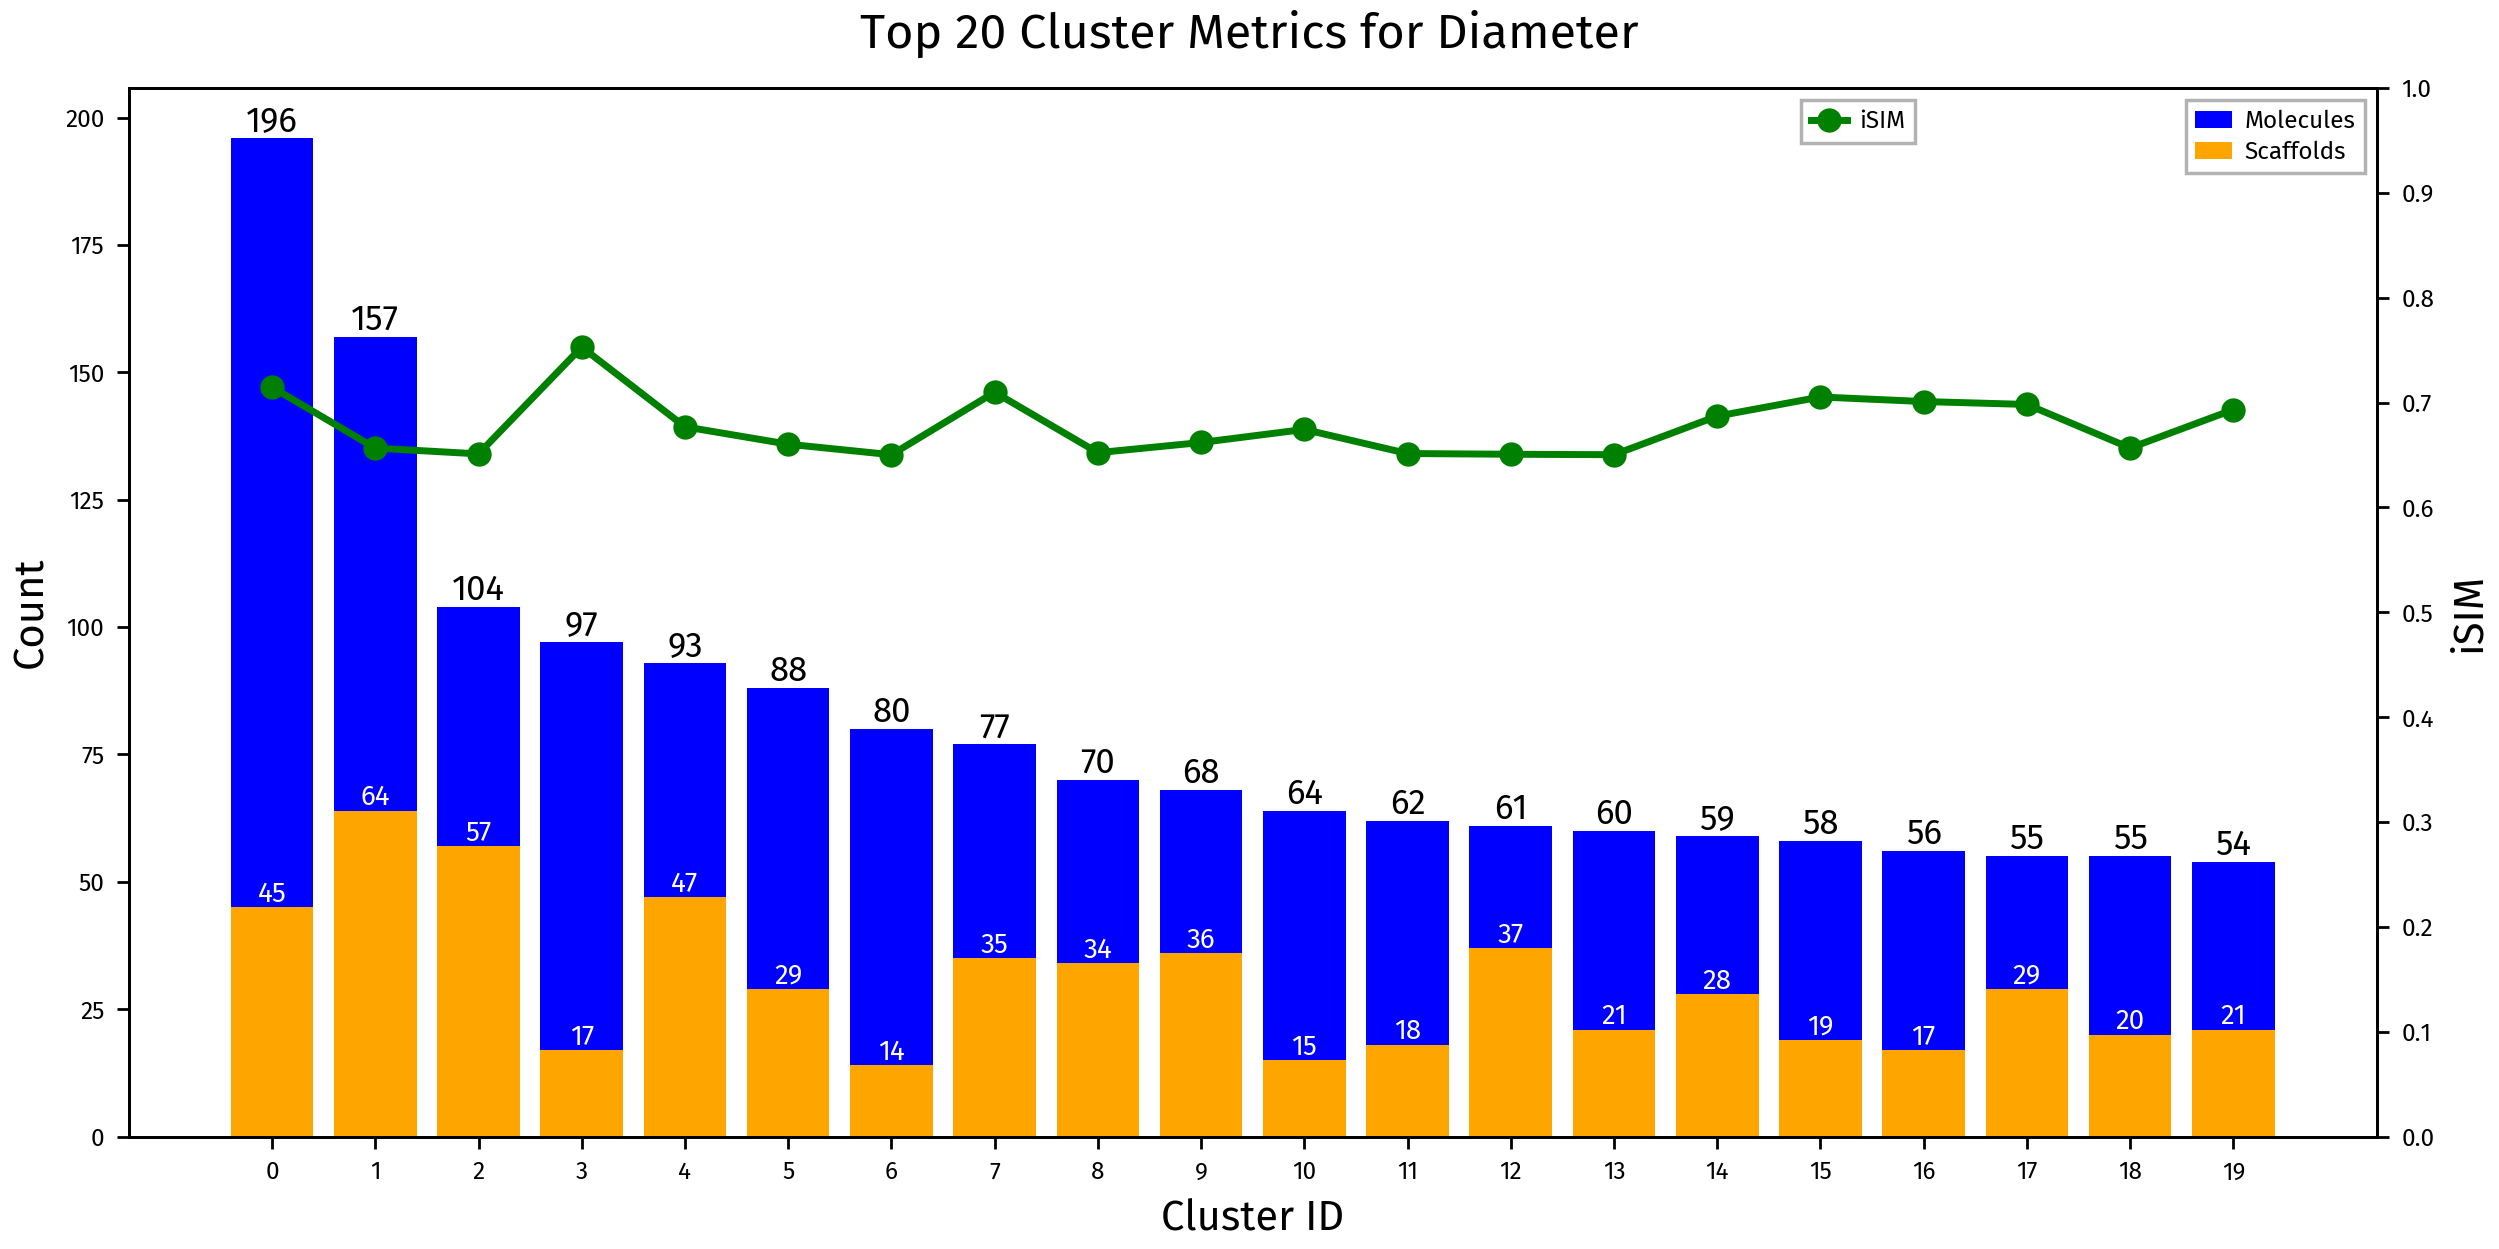

In [5]:
# First we run a cluster analysis on the resulting ids
clusters = bb_tree.get_cluster_mol_ids()
ca = analysis.cluster_analysis(clusters, smiles, fps)
# Afterwards we can use the utility functions on the bblean.plotting module
plotting.summary_plot(ca, title="Diameter")
# Optionally we can save the cluster analysis metrics as a csv file
ca.dump_metrics("./diameter-metrics.csv")
plt.show()

## Refining the clustering results

You may have noticed that there is a pretty big cluster with a large number of
scaffolds, which is undesirable. We will refine the tree by breaking appart the largest
cluster and re-inserting all the bit features. This step is only required if your
results display this problem. If they don't, you are done, no need to refine.

For the refinement, we will use the 'tolerance' merge criterion, a slightly higher
threshold, and a tolerance value of 0.05. `BitBirch.set_merge(...)` can be used to
specify the new criterion, and `BitBirch.refine_inplace(...)` breaks apart
the largest cluster and regenerates the tree with our new criterion.

In [6]:
# Modify the merge criteria for the tree, from now on bb_tree will use this new criteria
bb_tree.set_merge(threshold=0.70, merge_criterion="tolerance", tolerance=0.05)

# Refine the tree using the new merge criteria
bb_tree.refine_inplace(fps)

BitBirch(threshold=0.7, branching_factor=50, merge_criterion='tolerance', tolerance=0.05)

Lets visualize the refined results:

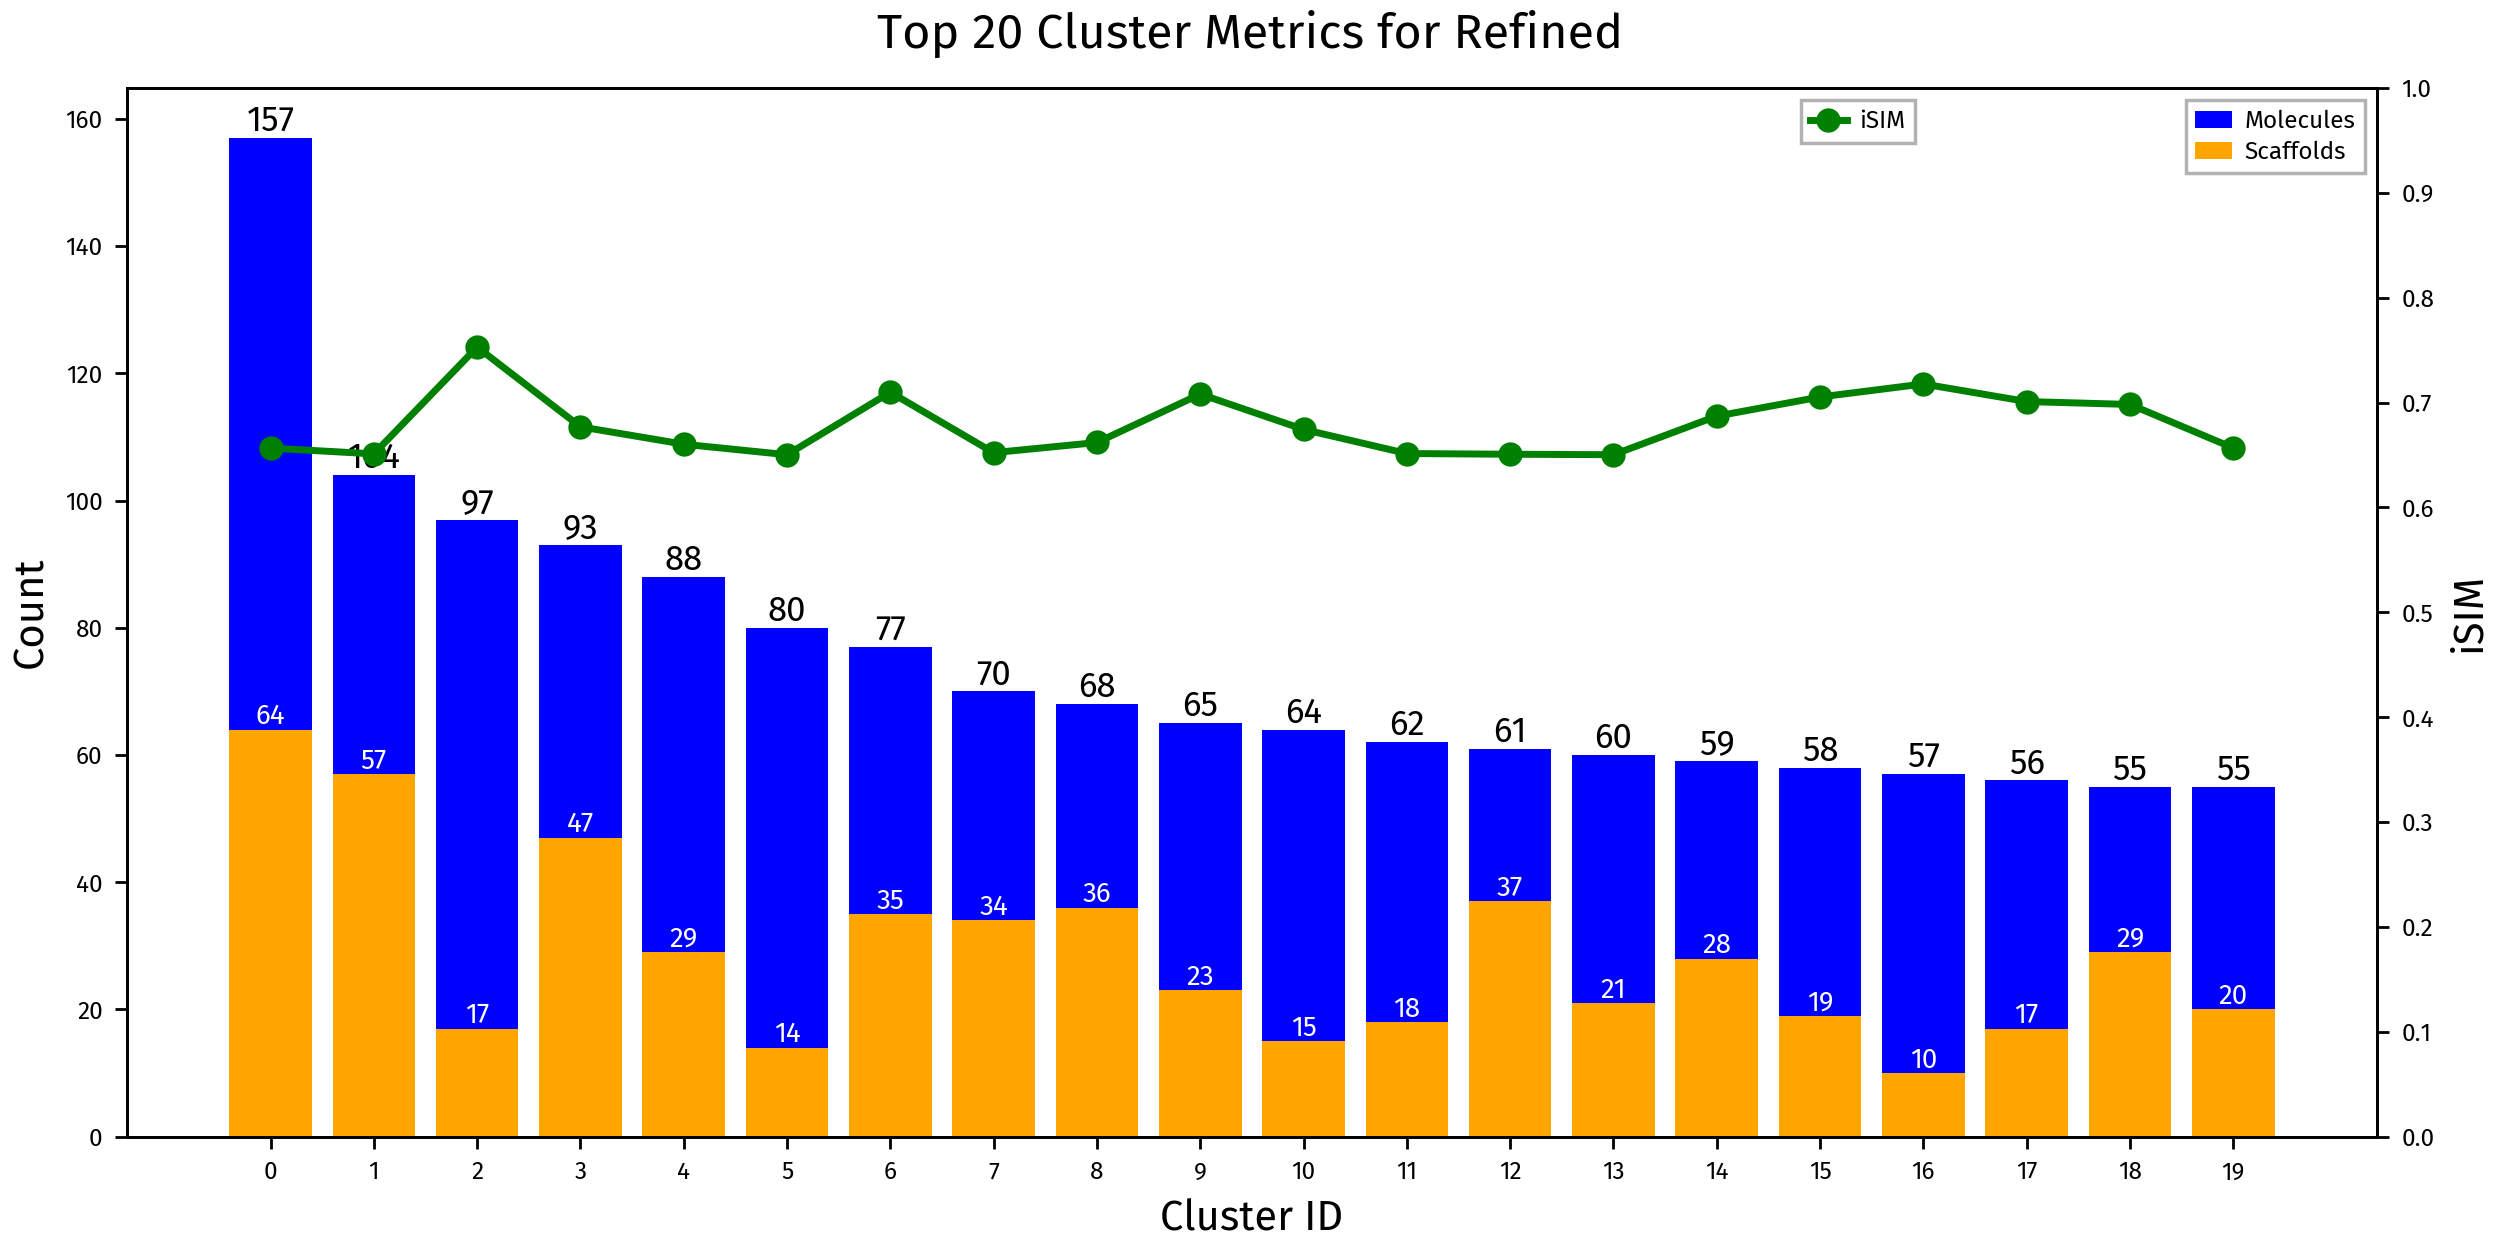

In [7]:
clusters_refined = bb_tree.get_cluster_mol_ids()
ca_refined = analysis.cluster_analysis(clusters_refined, smiles, fps)
plotting.summary_plot(ca_refined, title="Refined")

# Again, we can save the cluster analysis metrics as a csv file
ca.dump_metrics("./refined-metrics.csv")
plt.show()

## Further analysis and Visualization

Lets inspect some features of the generated clusters:

In [8]:
# Total clusters
print("Number of clusters: ", len(clusters_refined))

# Clusters with more than 10 molecules
large_clusters = [c for c in clusters_refined if len(c) > 10]
print("Number of clusters with more than 10 molecules: ", len(large_clusters))

Number of clusters:  789

Number of clusters with more than 10 molecules:  109

We can visually inspect an individual cluster by calling
`plotting.dump_mol_images`. By default this generates multiple images with 30
molecules each.

In [9]:
plotting.dump_mol_images(smiles, clusters_refined, cluster_idx=10)

We can also visualize the clusters using a t-SNE plot with `plotting.tsne_plot`:

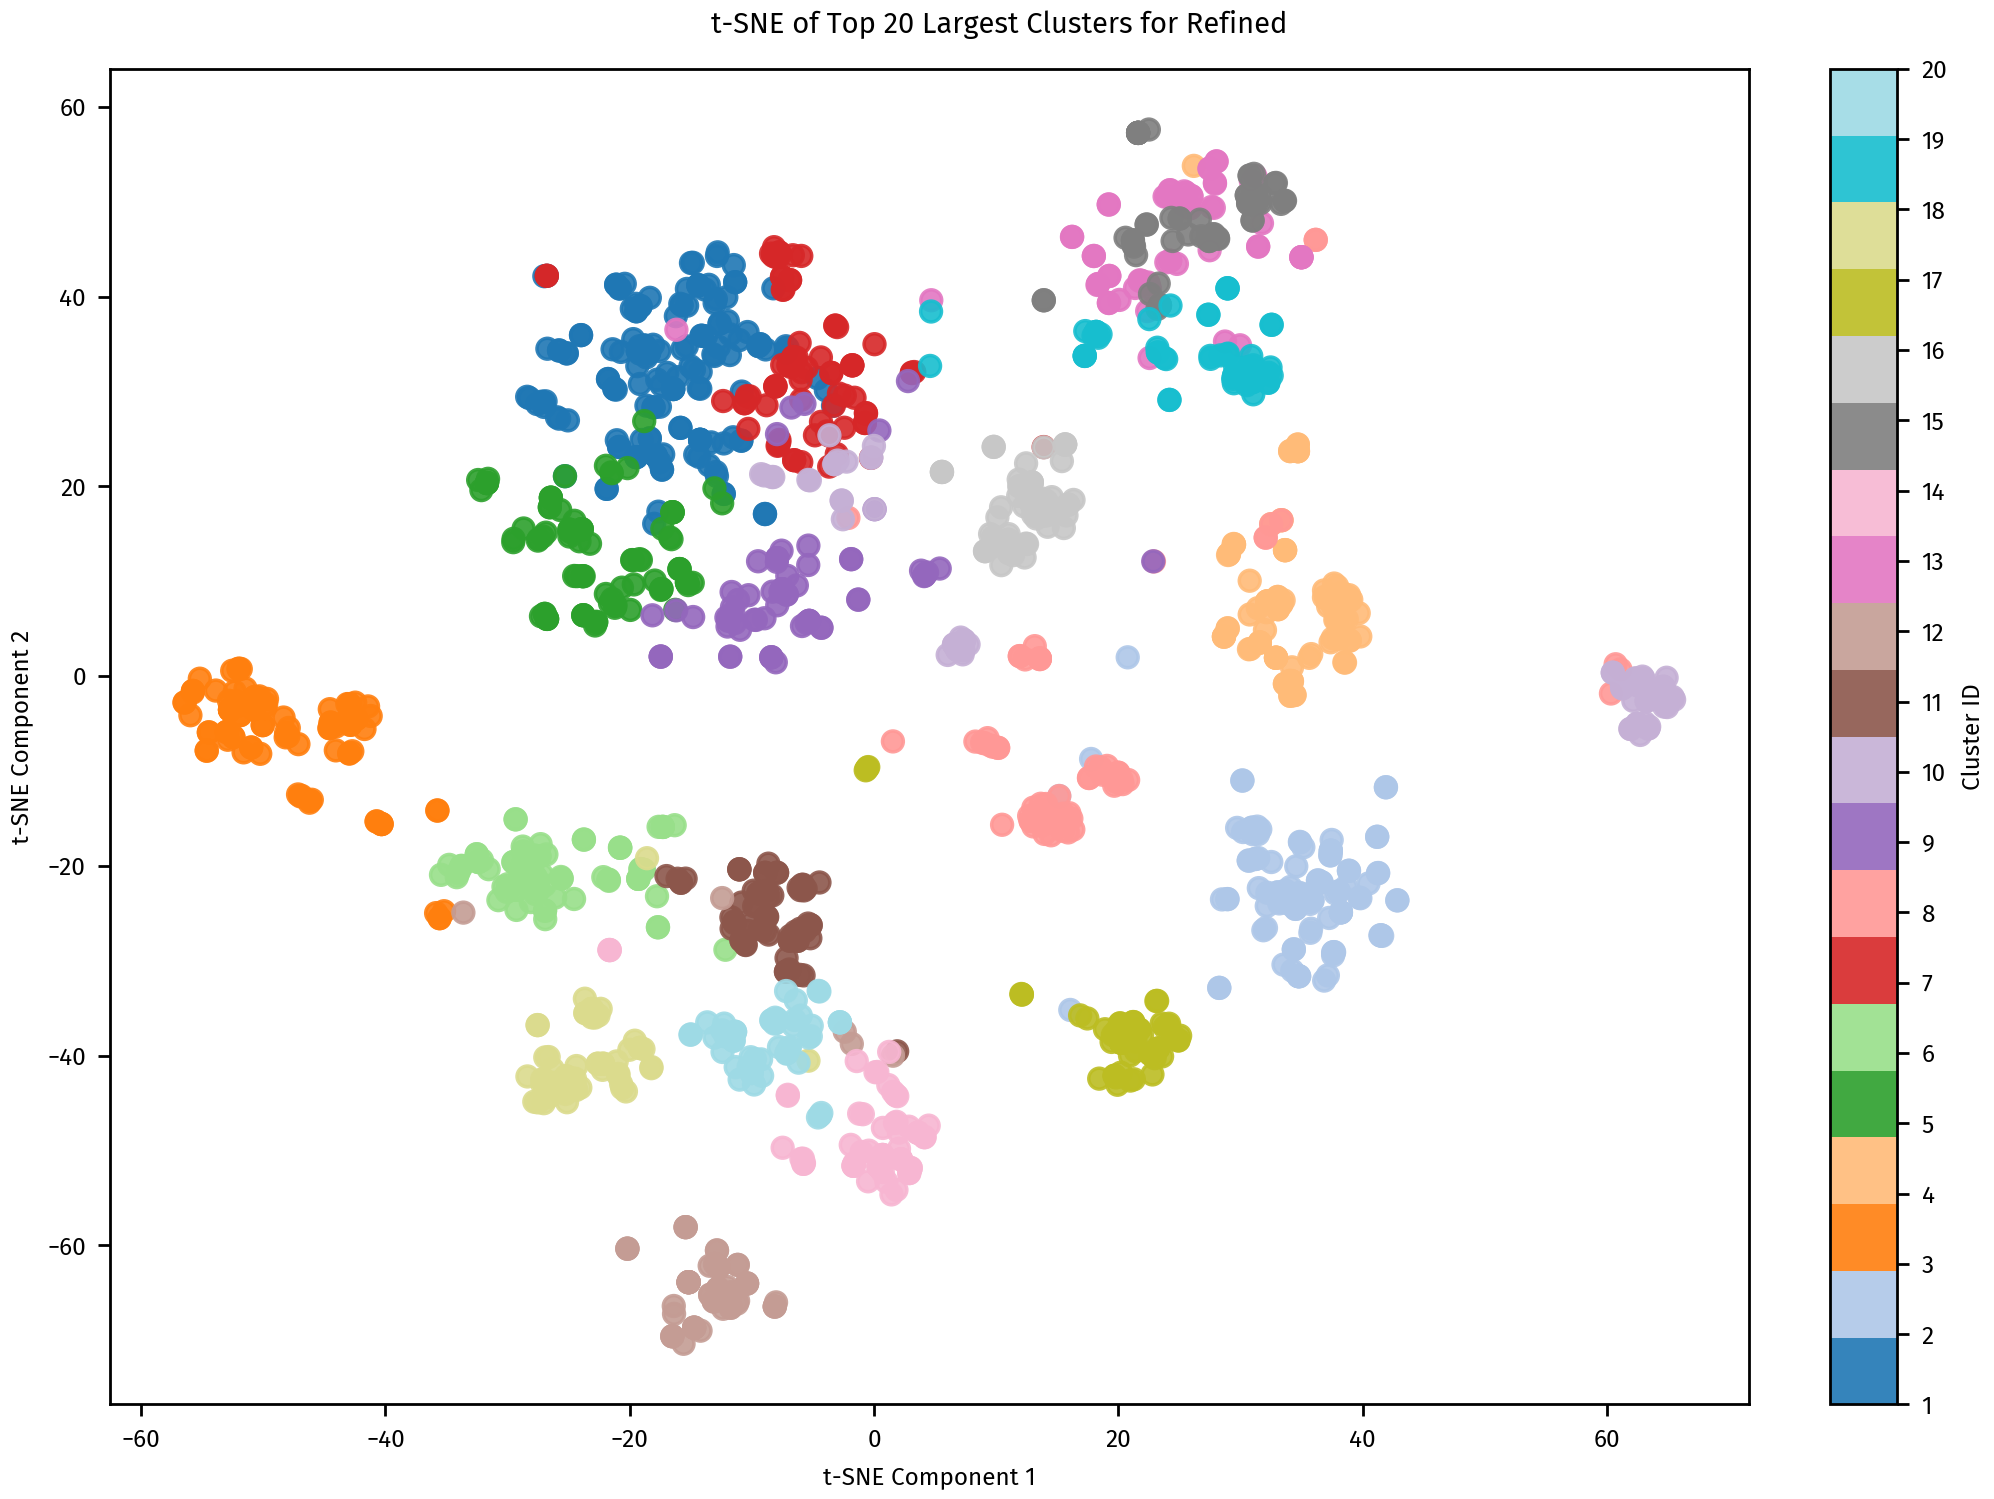

In [9]:
plotting.tsne_plot(ca_refined, title="Refined")
plt.show()

## Final cluster assignments

Once we are happy with the clustering results, we can save the final cluster
assignments. to a `*.csv` file.

In [11]:
bb_tree.dump_assignments("smiles-assignments.csv", smiles)